In [1]:
!pip install gwpy
%matplotlib inline

     |████████████████████████████████| 1.4MB 2.9MB/s 
     |████████████████████████████████| 51kB 5.5MB/s 
     |████████████████████████████████| 61kB 7.6MB/s 
     |████████████████████████████████| 2.3MB 44.8MB/s 
  Created wheel for ligo-segments: filename=ligo_segments-1.2.0-cp36-cp36m-linux_x86_64.whl size=83622 sha256=3fe81d234b383713a94aad3427e3b808ec0afe0f39c71fb8ffb82c6f286d884a
  Stored in directory: /root/.cache/pip/wheels/5d/1e/4a/ab4122baed7d67f6abce65b2b12049d3bc7fe5dad24edf89df
Successfully built ligo-segments


# Studying noise with GWpy

All of what we have seen already relates to studying signals we already know are in the data.
We will see tomorrow much more on how we actually find those signals in the first place, but for now let me assure that its hard.

We had to do a lot of filtering just to resolve a signal we already knew was there, so in this section we'll study a few types of noise.

We can use the same tools as before to find and study transient noise, commonly called 'glitches'.

## Hardware injections

But first, a quick aside.

LIGO data includes simulated signals known as hardware injections, used to test the effectiveness of our data handling and analysis workflows. For more details, see the O1 hardware injection page: https://losc.ligo.org/o1_inj/

We can use the links under '_Tables of transient injections_' to visualise a couple of these.

The first few injections in the H1 table are bursts, either 'white noise' or 'sine-gaussian', lets take a look at one of those:

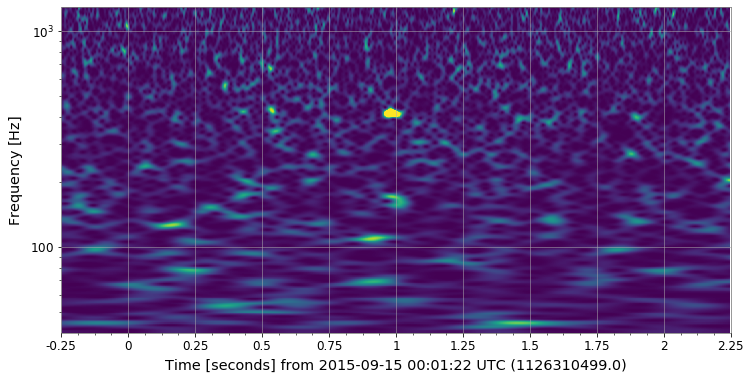

In [2]:
# format our times
injstart, injend = 1126310499.75, 1126310500.25
datastart = int(injstart) - 4
dataend = int(injend) + 4

# fetch the data
from gwpy.timeseries import TimeSeries
hdata = TimeSeries.fetch_open_data('H1', datastart, dataend, cache=True)

# generate the Q-transform
qtrans = hdata.q_transform(outseg=(injstart-1, injend+1))

# plot
plot = qtrans.plot(vmin=0, vmax=20, yscale='log')
plot.show()

We can determine the exact GPS time and frequency of the injection by matching the loudest pixel in Q-transform.

In [0]:
idx = qtrans.argmax()

The [`argmax`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.argmax.html) function returns the index of the loudest pixel in the flattened array, so we need to convert this back into an index on the time axis, and on the frequency axis.
We can do this using [`numpy.unravel_index`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.unwrap_index.html) and then extract the relevant index of the underlying `times` and `frequencies` arrays for our `Spectrogram`:

In [4]:
# get indices for times and frequencies
from numpy import unravel_index
timeid, freqid = unravel_index(idx, qtrans.shape)

# extract values (using .value to extract as a float)
peakgps = qtrans.times[timeid].value
peakfrequency = qtrans.frequencies[freqid].value
print(peakgps, peakfrequency)

1126310499.98 415.01407


Just as a sanity check, we can mark on our plot those coordinates, and see if they line up:

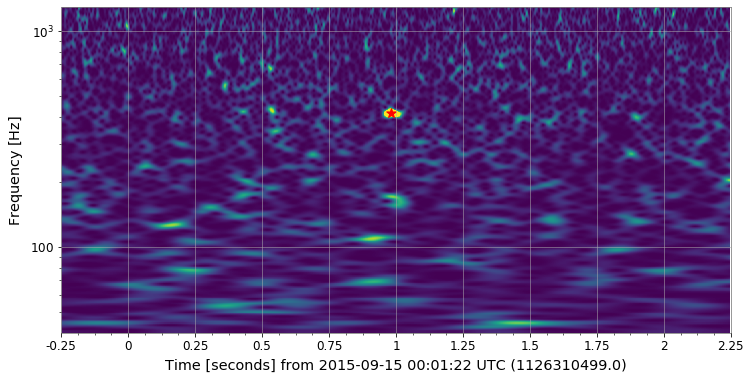

In [5]:
ax = plot.gca()
ax.scatter([peakgps], [peakfrequency], marker='*', color='red', s=100)
plot

Nailed it.

## Transient noise

As well as hardware injections, there are lots of loud bangs in GW data that aren't associated with gravitational-wave signals. We can use the same procedure as above to localise many different types of glitches.

### Challenges:

- there's a short glitch called a 'Koi fish' somewhere in Hanford data between 1132401017 and 1132401617 (November 24 2015 11:50-12:00), please find it and make a plot
- there's a subtle broadband noise called 'scratchy' somewhere around 1128779800